In [37]:
from matplotlib import pyplot as plt
from utils import error_analysis
import numpy as np

In [90]:
import pandas as pd
import numpy as np
from plotly import graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8

class error_analysis:
    
    def __init__(self, name, key,n_feat=10000,multi=None):
        self.x_train = []
        self.x_test = []
        self.errors = []

        for f in range(5):
            self.df_train = pd.read_csv('../{}/folds/train_f{}.csv'.format(name,f+1),index_col=0)
            self.df_test = pd.read_csv('../{}/folds/test_f{}.csv'.format(name,f+1),index_col=0)
            x_train_f =  self.df_train.values
            if multi is not None:
                x_test_f =  self.df_test.drop(multi,axis=1).values
            else:
                x_test_f =  self.df_test.drop(key,axis=1).values
            errors_f =  self.df_test[key].values

            self.x_train.append(x_train_f[:,:n_feat])
            self.x_test.append(x_test_f[:,:n_feat])
            self.errors.append(errors_f)

        self.x = np.concatenate(self.x_test)

        self.x_train_sc = []
        self.x_test_sc = []
        self.scaler = StandardScaler()
        self.x_sc = self.scaler.fit_transform(self.x)
        for f in range(5):
            self.x_train_sc.append(self.scaler.fit_transform(self.x_train[f]))
            self.x_test_sc.append(self.scaler.fit_transform(self.x_test[f]))

        self.x_train_scmm = []
        self.x_test_scmm = []
        self.scaler = MinMaxScaler()
        self.x_scmm = self.scaler.fit_transform(self.x)
        for f in range(5):
            self.x_train_scmm.append(self.scaler.fit_transform(self.x_train[f]))
            self.x_test_scmm.append(self.scaler.fit_transform(self.x_test[f]))
        
        
    def run_pca(self, n_pc=10):
        self.pca = PCA(n_components=n_pc)
        self.pc = self.pca.fit_transform(self.x_sc)
        
        self.x_train_pc = []
        self.x_test_pc = []
        for f in range(5):
            self.x_train_pc.append(self.pca.transform(self.x_train_sc[f]))
            self.x_test_pc.append(self.pca.transform(self.x_test_sc[f]))
        
        for comp_n in range(3):
            print('-'*50)
            print('Component {}'.format(comp_n+1))
            print('-'*50)
            max_ids = np.abs(self.pca.components_[comp_n]).argsort()[::-1][:10]
            for f,a in zip(self.df_test.columns[max_ids],self.pca.components_[comp_n,max_ids]):
                print('{:.1f}% of {}'.format(a*100,f))
            print('\n')
            
        print('Explained variance')
        for i,v in enumerate(self.pca.explained_variance_ratio_):
            print('PC {}: {:.1f}%'.format(i+1,v*100))
        
    def plot_pca(self,pc1=1,pc2=2):
        fig, axs = plt.subplots(2,3,figsize=(25,15))

        for fold in range(5):
            ax = (axs.flat)[fold]
            ax.scatter(self.x_train_pc[fold][:,pc1-1],self.x_train_pc[fold][:,pc2-1],c='k',alpha=0.5)
            sc = ax.scatter(self.x_test_pc[fold][:,pc1-1],self.x_test_pc[fold][:,pc2-1],marker='X',c=np.log(1+np.abs(self.errors[fold])))
            fig.colorbar(sc, ax=ax)
            ax.set_xlabel('PC {}'.format(pc1))
            ax.set_ylabel('PC {}'.format(pc2))
            ax.set_title('fold {}'.format(fold+1))

            #MAE
            mae = np.mean(np.absolute(self.errors[fold]))
            ax.text(0.6,0.8,'MAE: {:.2f}'.format(mae),transform=ax.transAxes,fontsize=14)
        return fig, axs
        
        
    def plot_pca_3D(self,fold=0,classification=False):
        xd = np.concatenate([self.x_train_pc[fold],self.x_test_pc[fold]])
        if classification:
            colors = np.concatenate([np.ones(len(self.x_train_pc[fold]))*-1,np.log(1+np.abs(self.errors[fold]))])
        else:
            colors = np.concatenate([np.ones(len(self.x_train_pc[fold]))*-0.1,np.log(1+np.abs(self.errors[fold]))])
        symbols = ['circle']*len(self.x_train_pc[fold]) + ['x']*len(self.x_test_pc[fold])
        
        fig=go.Figure(data=go.Scatter3d(x=xd[:,0],y=xd[:,1],z=xd[:,2],
                                        mode='markers',marker=dict(size=4,color=colors,symbol=symbols,showscale=True)))
        fig.show()
        return fig
    
    def plot_pca_distance(self,n_neighbours = 5, n_pc = 10, xmax=None, ymax=None):

        fig, axs = plt.subplots(2,3,figsize=(25,15))
        all_closest = []
        for fold in range(6):
            if fold == 5:
                closest = np.concatenate(all_closest)
                errs = np.abs(np.concatenate(self.errors))
            else:
                train = self.x_test_pc[fold]
                test = self.x_test_pc[fold]
                dist = euclidean_distances(test[:,:n_pc],train[:,:n_pc])
                closest = np.sort(dist,axis=1)[:,:n_neighbours].mean(axis=1)
                all_closest.append(closest)
                errs = np.abs(self.errors[fold])


            ax = axs.flat[fold]
            ax.plot(closest,errs,'o',alpha=0.5)

            # 1st order fit
            pfit = np.polyval(np.polyfit(closest,errs,1),closest)
            ax.plot(closest,pfit,'--')

            # Pearson correlation
            corr = pearsonr(closest,errs)[0]
            ax.text(0.6,0.9,'corr: {:.2f}'.format(corr),transform=ax.transAxes,fontsize=14)

            #MAE
            mae = np.mean(errs)
            ax.text(0.6,0.8,'MAE: {:.2f}'.format(mae),transform=ax.transAxes,fontsize=14)

            ax.set_xlabel('Euclidean PCA distance')
            ax.set_ylabel('Absolute error')
            if xmax is not None:
                ax.set_xlim(0,xmax)
            if ymax is not None:
                ax.set_ylim(0,ymax)
        return fig, axs
    
    
    def plot_feat_distance(self, n_neighbours = 5, n_feat = 50, scaling= 'mm', abs_v=True, xmax=None, ymax=None):
        
        #####
        fig, axs = plt.subplots(2,3,figsize=(25,15))

        if scaling == 'mm':
            xd_train = self.x_train_scmm
            xd_test = self.x_test_scmm
        else:
            xd_train = self.x_train_sc
            xd_test = self.x_test_sc

        all_closest = []
        for fold in range(6):
            if fold == 5:
                closest = np.concatenate(all_closest)
                if abs_v:
                    errs = np.abs(np.concatenate(self.errors))
                else:
                    errs = np.concatenate(self.errors)
            else:
                train = xd_test[fold]
                test = xd_test[fold]
                dist = euclidean_distances(test[:,:n_feat],train[:,:n_feat])
                closest = np.sort(dist,axis=1)[:,:n_neighbours].mean(axis=1)
                all_closest.append(closest)
                if abs_v:
                    errs = np.abs(self.errors[fold])
                else:
                    errs =self.errors[fold]


            ax = axs.flat[fold]
            ax.plot(closest,errs,'o',alpha=0.5)

            # 1st order fit
            pfit = np.polyval(np.polyfit(closest,errs,1),closest)
            ax.plot(closest,pfit,'-')

            # Pearson correlation
            corr = pearsonr(closest,errs)[0]
            ax.text(0.6,0.9,'corr: {:.2f}'.format(corr),transform=ax.transAxes,fontsize=14)

            #MAE
            mae = np.mean(errs)
            ax.text(0.6,0.8,'MAE: {:.2f}'.format(mae),transform=ax.transAxes,fontsize=14)

            ax.set_xlabel('Euclidean feature distance')
            ax.set_ylabel('Absolute error')
            if xmax is not None:
                ax.set_xlim(0,xmax)
            if ymax is not None:
                ax.set_ylim(0,ymax)
        return fig, axs
    
    def upper_bound(self,distances,errors,threshold=0.9):
        coeffs = errors/distances
        return np.sort(coeffs)[int(len(distances)*threshold)]
    
    def plot_feat_distance_all(self, ax=None, name='', upper_bound=1, n_neighbours = 5,
                               n_feat = 50, scaling= 'mm', abs_v=True, xmax=None, ymax=None, jointplot=False,
                              xlog=False,
                              ylog=False,
                              bins=20):

        if scaling == 'mm':
            xd_train = self.x_train_scmm
            xd_test = self.x_test_scmm
        else:
            xd_train = self.x_train_sc
            xd_test = self.x_test_sc

        all_closest = []
        for fold in range(6):
            if fold == 5:
                closest = np.concatenate(all_closest)
                if abs_v:
                    errs = np.abs(np.concatenate(self.errors))
                else:
                    errs = np.concatenate(self.errors)
                
                upper_coeff = self.upper_bound(closest,errs,threshold=0.90)
                
                if jointplot:
                    
                    
                    #g = sns.jointplot(closest,errs,kind='kde')
                    
                    sns.set_theme(style="ticks")
                    g = sns.JointGrid(x=closest, y=errs, marginal_ticks=False)

                    # Set a log scaling on the y axis
                    if xlog:
                        g.ax_joint.set(xscale="log")
                    if ylog:
                        g.ax_joint.set(yscale="log")

                    # Create an inset legend for the histogram colorbar
                    cax = g.fig.add_axes([.15, .55, .02, .2])

                    # Add the joint and marginal histogram plots
                    g.plot_joint(
                        sns.histplot, discrete=(False, False),
                         cbar=True, cbar_ax=cax
                    )
                    #g.plot_marginals(sns.histplot, element="step", color="#03012d")
                    #pfit = np.polyval([upper_coeff,0],closest)
                    #g.ax_joint.plot(closest,pfit,':r')
                    
                    g.set_axis_labels('Euclidean feature distance', 'Absolute error', fontsize=16)
                    
                    # Pearson correlation
                    corr = pearsonr(closest,errs)[0]
                    g.ax_joint.text(0.05,0.9,'r = {:.2f}'.format(corr),transform=g.ax_joint.transAxes,fontsize=12)
                    
                    # MAE
                    mae = np.mean(errs)
                    g.ax_joint.axhline(y=mae, color='r', linestyle='-')
                    

                else:
                    #ylog = True
                    ax.set_xscale('log')
                    if ylog:
                        ax.set_yscale('log')
                    #ax.hist2d(closest,errs,bins=bins,cmin=1)
                    ax.plot(closest,errs,'+',ms=2,mew=0.2,alpha=0.3,color='midnightblue',rasterized=True)
                    # 1st order fit
                    if ylog:
                        pfit = 10**(np.polyval(np.polyfit(np.log10(closest),np.log10(errs),1),np.log10(closest)))
                    else:
                        pfit = np.polyval(np.polyfit(np.log10(closest),errs,1),np.log10(closest))
                        #pfit = np.polyval([upper_coeff,0],closest)
                    ax.plot(closest,pfit,':',lw=0.5,color='midnightblue')
                    
                    
                    #Draw a red circle around highest error
                    highest_idx = errs.argmax()
                    ax.plot(closest[highest_idx],errs[highest_idx],'o',markerfacecolor="None",
                            markeredgecolor='red', markeredgewidth=0.5, ms=4, alpha=0.6)
                    
                    # Pearson correlation
                    corr = pearsonr(closest,errs)[0]
                    ax.text(0.05,0.8,'r = {:.2f}'.format(corr),transform=ax.transAxes,fontsize=8)

                    # MAE
                    mae = np.mean(errs)
                    if 'bulk' in name: # without oulier
                        mae = 0.0633
                    ax.axhline(y=mae, color='green', linestyle=':',lw=0.7)
                    #ax.text(0.8,0.02,'MAE',transform=ax.transAxes,color='green',fontsize=5)

                    #ax.text(0.5,0.8, name, transform=ax.transAxes, fontsize=8)
                    ax.set_title(name)
                    
                    ax.set_xlabel('Euclidean feature distance',fontsize=10)
                    ax.set_ylabel('Absolute error',fontsize=10)
                    if xmax is not None:
                        ax.set_xlim(0,xmax)
                    if ymax is not None:
                        ax.set_ylim(0,ymax)
                    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
                    
                    ### BINNING ####
                    
                    max_cl = closest.max()
                    min_cl = closest.min()
                    v = np.geomspace(min_cl,max_cl,8)
                    v[0]-=10e-9
                    m_closest=[]
                    m_errs=[]
                    #std_errs=[]
                    for i in range(len(v)-1):
                        idx = (closest>v[i]) & (closest<=v[i+1])
                        #m_errs.append(np.sqrt((errs[idx]**2).mean()))
                        m_errs.append(errs[idx].mean())
                        #std_errs.append(errs[idx].std())
                        m_closest.append((v[i]+v[i+1])/2)
                    ax.plot(m_closest,m_errs,'o',ms=0.7)
                    #ax.plot(m_closest,std_errs,'x',ms=0.7)
                
            else:
                train = xd_test[fold]
                test = xd_test[fold]
                dist = euclidean_distances(test[:,:n_feat],train[:,:n_feat])
                closest = np.sort(dist,axis=1)[:,:n_neighbours].mean(axis=1)
                all_closest.append(closest)
                if abs_v:
                    errs = np.abs(self.errors[fold])
                else:
                    errs =self.errors[fold]

In [91]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

<ipython-input-90-eb15672731ad>:328: RuntimeWarning: Mean of empty slice.
  m_errs.append(errs[idx].mean())
/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-90-eb15672731ad>:328: RuntimeWarning: Mean of empty slice.
  m_errs.append(errs[idx].mean())
/Users/ppdebreuck/anaconda3/envs/modnet/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


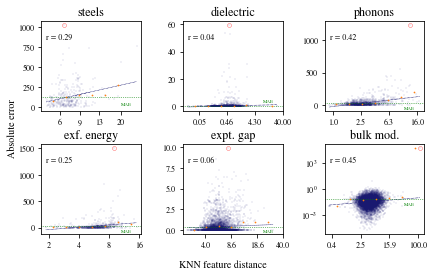

In [92]:
fig,axs = plt.subplots(2,3,figsize=(6.5,4.2))
axs = axs.flat

steels = error_analysis('matbench_steels','sigma_error')
steels.plot_feat_distance_all(axs[0],name='steels', n_neighbours = 25, n_feat = 200, scaling= 'n',bins=30)

dielectric = error_analysis('matbench_dielectric','n_error')
dielectric.plot_feat_distance_all(axs[1], name='dielectric', n_neighbours = 5, n_feat = 7, scaling= 'n',bins=100)

phonons = error_analysis('matbench_phonons','w_error')
phonons.plot_feat_distance_all(axs[2], name='phonons', n_neighbours = 5, n_feat = 50, scaling= 'n')

exf = error_analysis('matbench_jdft2d','E_error')
exf.plot_feat_distance_all(axs[3], name='exf. energy', n_neighbours = 5, n_feat = 500, scaling= 'n')

expt_gap = error_analysis('matbench_expt_gap','E_g_error')
expt_gap.plot_feat_distance_all(axs[4], name='expt. gap', n_neighbours = 25, n_feat = 500, scaling= 'n')

k = error_analysis('matbench_elastic','K_error',multi=['K_error','G_error'])
k.plot_feat_distance_all(axs[5], name='bulk mod.', n_neighbours = 5, n_feat = 150, scaling= 'n', ylog=True)

axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[3].set_ylabel('')
axs[4].set_ylabel('')
axs[5].set_ylabel('')

axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
axs[3].set_xlabel('')
axs[4].set_xlabel('')
axs[5].set_xlabel('')

#axs[3].xaxis.set_ticks([2,3])
#axs[3].xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#axs[3].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))

axs[0].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[0].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[0].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticks([6,9,13,20])

axs[1].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[1].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[1].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].set_xticks([0.05,0.46,4.3,40])

axs[2].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[2].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[2].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[2].set_xticks([1,2.5,6.3,16])

axs[3].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[3].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[3].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[3].set_xticks([2,4,8,16])

axs[4].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[4].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[4].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[4].set_xticks([4,8.6, 18.6,40])

axs[5].xaxis.set_major_locator(matplotlib.ticker.NullLocator())
axs[5].xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
axs[5].xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[5].set_xticks([0.4,2.5,15.9,100])


axs[0].text(0.8,0.06,'MAE',transform=axs[0].transAxes,color='green',fontsize=5)
axs[1].text(0.8,0.1,'MAE',transform=axs[1].transAxes,color='green',fontsize=5)
axs[2].text(0.8,0.02,'MAE',transform=axs[2].transAxes,color='green',fontsize=5)
axs[3].text(0.8,0.02,'MAE',transform=axs[3].transAxes,color='green',fontsize=5)
axs[4].text(0.8,0.02,'MAE',transform=axs[4].transAxes,color='green',fontsize=5)
axs[5].text(0.8,0.32,'MAE',transform=axs[5].transAxes,color='green',fontsize=5)

#axs[5].ticklabel_format(style='sci', axis='y', scilimits=(0,3))
#axs[5].set_ylim([0.1,40000])
fig.tight_layout(pad=3,w_pad=1,h_pad=0.3)

fig.text(0.5, 0.04, 'KNN feature distance', ha='center')
fig.text(0.04, 0.5, 'Absolute error', va='center', rotation='vertical')

fig.savefig('feat_distance.pdf',dpi=300)

In [25]:
a = np.array([1,2,30])
a>3

array([False, False,  True])

In [292]:
np.geomspace(0.4,100,4)

array([  0.4       ,   2.5198421 ,  15.87401052, 100.        ])

In [192]:
import pandas as pd
df_train = pd.read_csv('../matbench_elastic/folds/train_f4.csv',index_col=0)
df_test = pd.read_csv('../matbench_elastic/folds/test_f4.csv',index_col=0)

In [18]:
df_test.loc['id6951','K_error']

-54107.83727485296

In [19]:
df_test = df_test.drop(['G_error','K_error'],axis=1)

In [20]:
df = df_train.append(df_test)

In [26]:
dev = (df.mean() - df.loc['id6951']).abs()/df.std()

In [27]:
dev.nlargest(n=25)

VoronoiFingerprint|std_dev Voro_area_sum                                   104.809349
VoronoiFingerprint|std_dev Voro_vol_sum                                    104.809343
VoronoiFingerprint|std_dev Voro_vol_mean                                   104.809340
VoronoiFingerprint|std_dev Voro_vol_std_dev                                104.809339
VoronoiFingerprint|mean Voro_area_maximum                                  104.809230
VoronoiFingerprint|mean Voro_area_mean                                     104.809219
VoronoiFingerprint|mean Voro_area_std_dev                                  104.809213
VoronoiFingerprint|mean Voro_vol_maximum                                   104.809202
VoronoiFingerprint|mean Voro_area_sum                                      104.809191
VoronoiFingerprint|mean Voro_vol_std_dev                                   104.809173
VoronoiFingerprint|mean Voro_vol_mean                                      104.809069
VoronoiFingerprint|mean Voro_vol_sum                  

In [27]:
import pandas as pd
pd.read_csv('../matbench_expt_gap/folds/test_f3.csv',index_col=0)['E_g_error'].abs().nlargest(n=5)

id
id2704    9.901901
id580     8.627182
id2037    6.951901
id2968    6.151901
id3717    5.652894
Name: E_g_error, dtype: float64

In [ ]:
5 10-5

# Joint plots

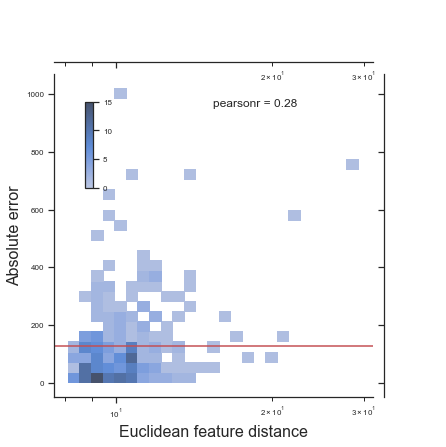

In [5]:
steels = error_analysis('matbench_steels','sigma_error')
steels.plot_feat_distance_all(name='steels', n_neighbours = 200, n_feat = 200, scaling= 'n',ymax=1000, jointplot=True,xlog=True)

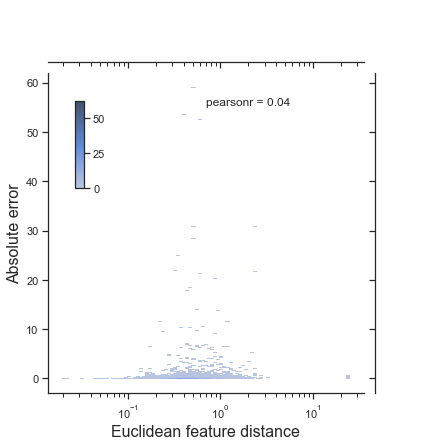

In [33]:
dielectric = error_analysis('matbench_dielectric','n_error')
dielectric.plot_feat_distance_all(name='dielectric', n_neighbours = 5, n_feat = 7, scaling= 'n',ymax=100, jointplot=True,xlog=True)

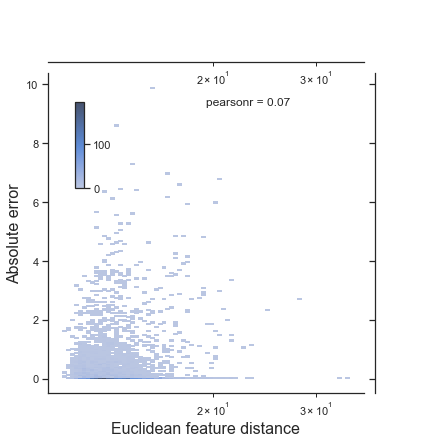

In [34]:
expt_gap = error_analysis('matbench_expt_gap','E_g_error')
expt_gap.plot_feat_distance_all(name='expt. gap', n_neighbours = 6000, n_feat = 500, scaling= 'n', jointplot=True,xlog=True)

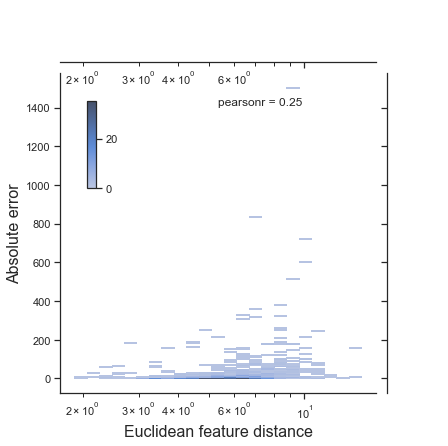

In [24]:
exf = error_analysis('matbench_jdft2d','E_error')
exf.plot_feat_distance_all(name='exf. energy', n_neighbours = 5, n_feat = 500, scaling= 'n', jointplot=True,xlog=True)

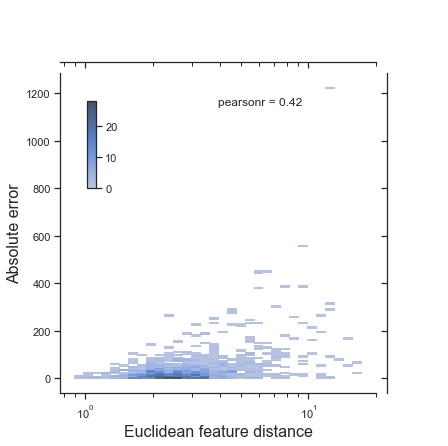

In [36]:
phonons = error_analysis('matbench_phonons','w_error')
phonons.plot_feat_distance_all(name='phonons', n_neighbours = 5, n_feat = 50, scaling= 'n', jointplot=True, xlog=True)

KeyboardInterrupt: 

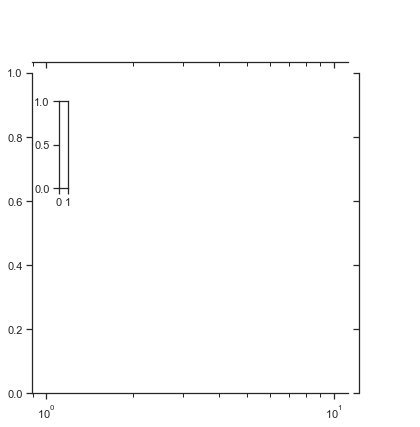

In [58]:
k = error_analysis('matbench_elastic','K_error',multi=['K_error','G_error'])
k.plot_feat_distance_all(name='bulk mod.', n_neighbours = 5, n_feat = 150, scaling= 'n', jointplot=True,xlog=True)